## Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


## Data preprocessing

In [2]:
# Function for removing unnecessary columns
def preprocess(df):
    
    # Remove unnecessary columns (partlybad, id, date, all .std-columns)
    df = df.filter(regex=(".*mean")) # Use only mean values for better interpretability of the results
    #df = df.drop("partlybad",axis=1) # Always false
    #df = df.drop("id",axis=1)
    #df = df.drop("date",axis=1) # Column full of NaN
    return df

In [3]:
# Read data to a dataframe
npf_train = pd.read_csv("npf_train.csv")
npf_test = preprocess(pd.read_csv("npf_test_hidden.csv"))

# Targets "y_class4", "y_class2" and features "X_train" created, event types changed to numerical values
y_class4 = npf_train["class4"].replace(["nonevent", "Ia", "Ib", "II"], [0, 1, 2, 3]).astype(int)
y_class4 = y_class4.astype(int)
y_class2 = y_class4.copy().replace([2, 3], 1)

# Remove unnecessary columns
X_train = preprocess(npf_train)
X_test = preprocess(npf_test)

# Normalize the features. NOTE: Type changes from Dataframe to Numpy array!
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# X_train = Dataframe
# X_train_scaled = Numpy Array
# y_class2 = Pandas Series
# y_class4 = Pandas Series

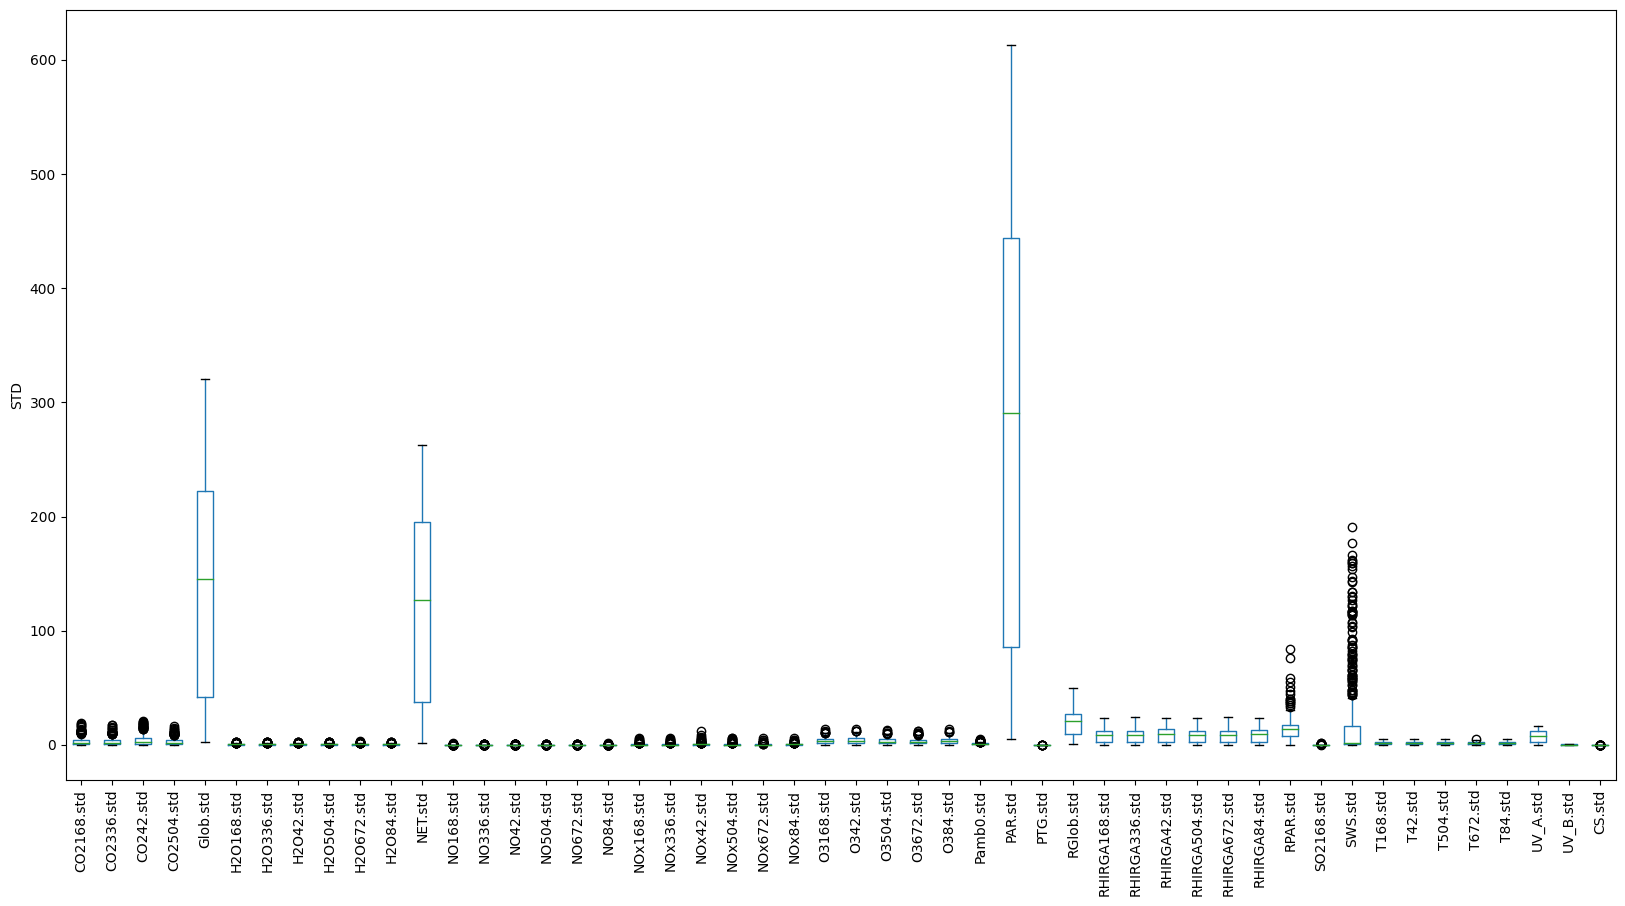

In [9]:
std_box = npf_train.filter(regex=(".*std")).boxplot(figsize=(20,10), rot=90, grid=False).set_ylabel('STD')

Text(0, 0.5, 'MEAN')

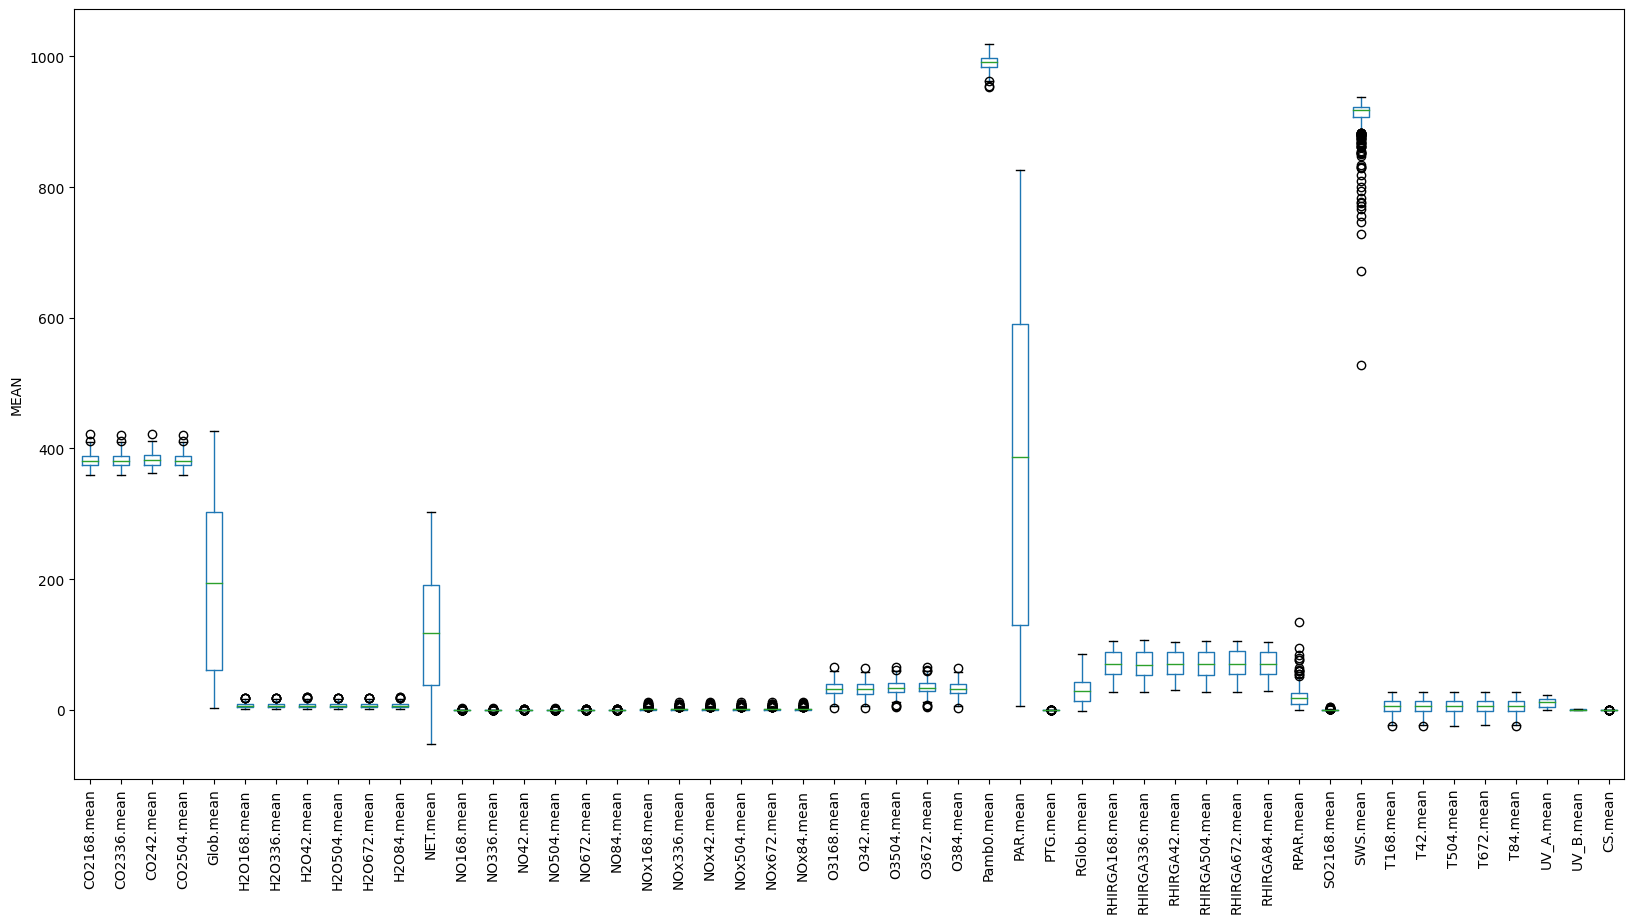

In [8]:
npf_train.filter(regex=(".*mean")).boxplot(figsize=(20,10), rot=90, grid=False).set_ylabel('MEAN')

## Feature selection

In [15]:
# Select k best features
selector = SelectKBest(f_classif, k=10).fit(X_train_scaled, y_class2)
feature_ind = selector.get_support()

In [16]:
# Most impotant features:
features_df_new = X_train.iloc[:,feature_ind]

In [17]:
features_df_new.columns

Index(['Glob.mean', 'PAR.mean', 'RGlob.mean', 'RHIRGA168.mean',
       'RHIRGA336.mean', 'RHIRGA42.mean', 'RHIRGA504.mean', 'RHIRGA672.mean',
       'RHIRGA84.mean', 'UV_A.mean'],
      dtype='object')

Text(0, 0.5, '5 most important')

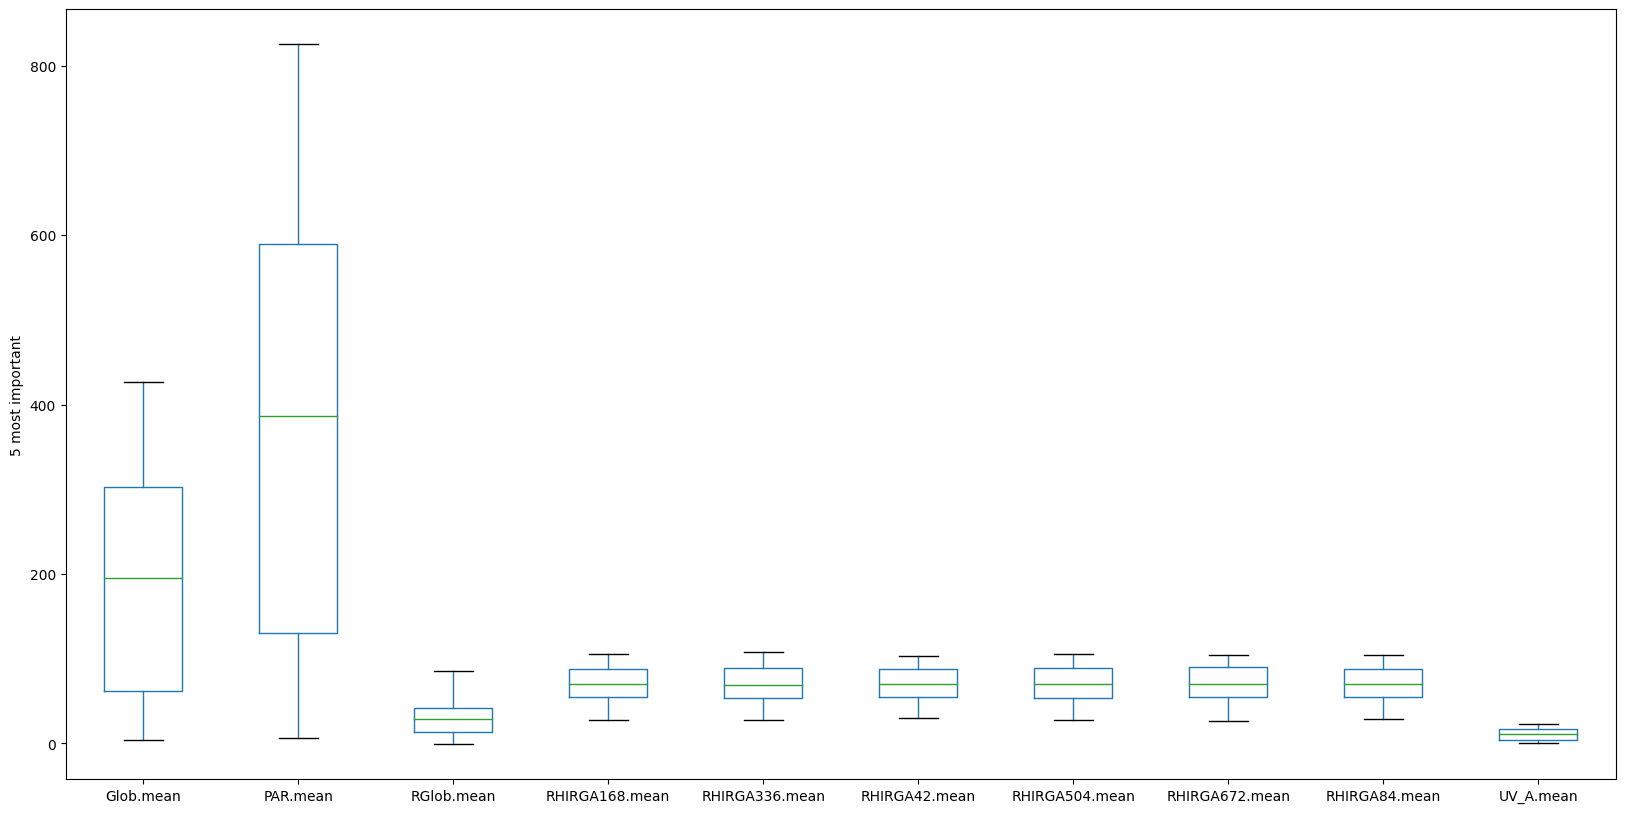

In [18]:
features_df_new.boxplot(figsize=(20,10), grid=False).set_ylabel('5 most important')

## Logistic regression

In [10]:
# Define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter = 1000)

# Model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Evaluate the model and collect the scores
n_scores = cross_val_score(model, X_train_scaled[:,feature_ind], y_class2, scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance
print('Mean Accuracy: %.8f (%.8f)' % (np.mean(n_scores), np.std(n_scores)))

# Fit the multinomial logistic regression model
model.fit(X_train_scaled[:,feature_ind], y_class4)

Mean Accuracy: 0.79656183 (0.04135641)


LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga')

## Predict classes and their probabilities for test data

In [11]:
# Multiclass prediction
y_class4_pred = model.predict(X_test_scaled[:,feature_ind])

# Probabilities for multiclass classification ("nonevent", "Ia", "Ib", "II")
multiclass_proba = model.predict_proba(X_test_scaled[:,feature_ind])


In [12]:
list(feature_ind).count(True)

5

In [13]:
# Accuracy estimate for the binary classification using multiclass model
model_bin = LogisticRegression(multi_class='multinomial', solver='saga', max_iter = 1000)
model_bin.fit(X_train_scaled[:,feature_ind], y_class2)
y_class2_pred = model_bin.predict(X_train_scaled[:,feature_ind])
1-sum(abs(y_class2-y_class2_pred))/len(y_class2)

0.7974137931034483

In [14]:
model_bin.score(X_train_scaled[:,feature_ind], y_class2)

0.7974137931034483

In [10]:
# Binary probabilities: the probability of an event is the sum of probabilities of "Ia", "Ib", "II"
bin_proba=[]

for i in range(len(y_class4_pred)):
    
    # Event probability is the sum of event type probabilities
    p_event = np.sum(multiclass_proba[i,1:])
    
    # Nonevent == 0
    # If nonevent probability does not match the predicted class,
    # change p to 0.49 (should always be < 0.5 for nonevents to match)
    if (y_class4_pred[i] == 0):
        
        if p_event >= 0.5:
            bin_proba.append(0.4999999999999999)
        else:
            bin_proba.append(p_event)

    else: # Event Ia, Ib or II == 1, 2, 3
        bin_proba.append(p_event)

In [11]:
# Create result file
res = pd.DataFrame({'Label': y_class4_pred, 'Probability': bin_proba})
res["Label"].replace([0, 1, 2, 3], ["nonevent", "Ia", "Ib", "II"], inplace=True)
res.head()
res.to_csv('res_multiclass.csv', index=False)

In [63]:
k_vals = [5, 10, 20, 25, 35, 50]
acc_vals = [0.7974137931034483, 0.8297413793103449, 0.8577586206896551, 0.8814655172413793, 0.898706896551724, 0.896551724137931]

In [64]:
cv_vals = [0.79656183, 0.81970398, 0.84421832, 0.86638915, 0.88287080, 0.88283996]

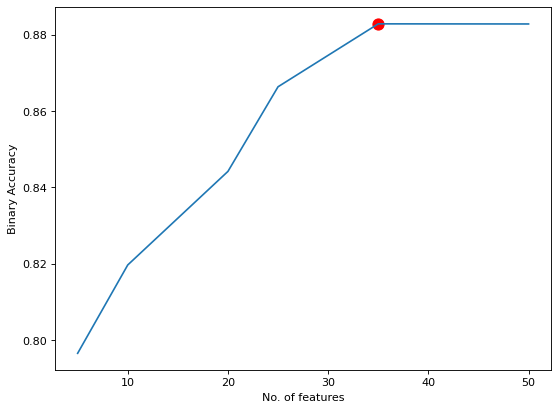

In [66]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.plot(k_vals, cv_vals)
plt.scatter(35, 0.88287080, c="r", s=100)
plt.xlabel("No. of features")
plt.ylabel("Binary Accuracy")
#plt.ylim([0.5, 1])
plt.show()